In [1]:
from modules.models import KdVPinn, create_dense_model
from modules.data import simulate_kdv
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-07-25 10:14:15.882182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [121]:
k=6
c= 3.23
phi = 0
def phi_function_PBC(tx,nx=2000,nt=2000):
    offset =  0
    ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    u = u.numpy().reshape(nx,-1)
    
    diff = c
    for i in range(1,nt):
        un = u[0:nx-diff-1,i-1].copy() #shifted to right but still in the frame
        u[diff+1:nx,i]= un # shift them to the right for next time frame
        u[0:diff+1,i] = u[-diff-1:nx,i-1] # the remaining first diff points are the old points -10:-1
    u = tf.reshape(tf.convert_to_tensor(u),(-1,1))
    return u


def phi_function(tx):
    
    offset =  +12
    ksi = tx[:, 1:2]-0.*tx[:,0:1]+offset
    ksi = tx[:, 1:2] + offset# in moving frame
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    return u
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# x_start = 0
# length = 8*np.pi
x_start =  -50. #-10
length = 50.#10
time =  10

In [126]:

c1 = 3.23 #3.25 
c2 = 0.5 #0.5

#c1 = 2.5
#c2 = 0.9
print(c1/c2)
phi = 0
# def phi_function(tx):
#     offset = 0
#     ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 5
#     ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] - 3

#     exact = 2*(c1-c2) * (c1*tf.cosh(tf.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(tf.sqrt(c1)*(ksi1)/2)**2))/ ((tf.sqrt(c1)-tf.sqrt(c2)) * tf.cosh((tf.sqrt(c1) * ksi1 + tf.sqrt(c2)* ksi2)/2) +  (tf.sqrt(c1)+tf.sqrt(c2)) * tf.cosh((tf.sqrt(c1)*ksi1-tf.sqrt(c2)*ksi2)/2))**2
#     return exact

def phi_function(tx, returnStuff = False):
    offset = -34
    ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] + 12
    ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] + offset
    numer = 2*(c1-c2) * (c1*tf.cosh(np.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(np.sqrt(c1)*(ksi1)/2)**2))
    denom = ((np.sqrt(c1)-np.sqrt(c2)) * tf.cosh((np.sqrt(c1) * ksi1 +np.sqrt(c2)* ksi2)/2) +  (np.sqrt(c1)+np.sqrt(c2)) * tf.cosh((np.sqrt(c1)*ksi1-np.sqrt(c2)*ksi2)/2))**2
    exact = numer/ denom
    exact = tf.where(tf.math.is_nan(exact), 0., exact)
    if returnStuff:
        return exact, denom, numer
    else:
        return exact
    
    
def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start = -50
length = 50
time = 10

6.46


### start skipping if you don't want to model an animation of the exact periodic solution

In [12]:
nt = 2000
nx = 2000
# int(np.pi*(dt**-1))+1
dx=(length-x_start)/(nx-1)
dt=time/(nt-1)
print(' dx is',dx/dt)



 dx is 6.3999999999999995


In [13]:
x_flat = np.linspace(x_start, length, nx)
t_flat = np.linspace(0, time, nt)
x_flat = tf.convert_to_tensor(x_flat)
t_flat = tf.convert_to_tensor(t_flat)
t_, x_ = tf.meshgrid(t_flat, x_flat)
tx_samples = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
# tx = tf.convert_to_tensor(tx)
print(type(t_))
solution = phi_function_PBC(tx_samples,nx,nt)
print(solution.shape)
print(x_flat.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(4000000, 1)
(2000,)


In [14]:
nx, nt = 256,201
solution = tf.reshape(solution, x_.shape)
print(solution[0,:].shape)

(2000,)


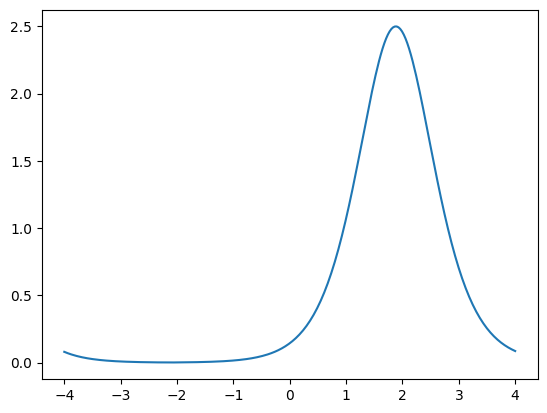

In [49]:
plt.plot(x_flat, solution[:,10])

In [ ]:
u_boundary = tf.reshape(solution[0, :], (-1, 1)) 
boundary_indices = tf.random.shuffle(tf.range(nt, dtype=tf.int32), seed=42)[:nx]
u_boundary = tf.gather(u_boundary, boundary_indices)

In [ ]:
u_boundary.shape
plt.plot(x_flat[:nt],u_boundary,'.')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( x_start, length))
ax.set_ylim((-0.01, np.sqrt(c)+0.5))

line, = ax.plot([], [], lw=2)
# line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    # line2.set_data([], [])
    return (line,)

In [ ]:
def animate(i):
    y=solution[:,i]
#     y2=vfull[:,i*10]
    line.set_data(x_flat,y,)
    
#     line2.set_data(x,y2)
    
    return(line,)

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int((nt-1)), interval=100) #frames is nt

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
f = r"KdVPBC.gif" 
writergif = animation.PillowWriter(fps=10) 
anim.save(f, writer=writergif)

# skip till here

In [140]:
# (tx_samples, y_res), (tx_init, u_init), (tx_bnd_start, u_bnd_start_exact), (tx_bnd_end, u_bnd_end_exact), (tx_boundary, y_boundary)= \
#     simulate_kdv(n_samples = 10000, init_function= phi_function, bnd_fcn=boundary_function, xstart=x_start, length=length, time=time, compute_periodic = False, solver_function = None, nx = 1000, nt = 1000, shuffle_bnd = False, n_init=None, n_bndry=None,random_seed = 42, dtype=tf.float32)

In [127]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdv(1000, phi_function, boundary_function, length, time, x_start,random_seed = 42, dtype=tf.float32) 


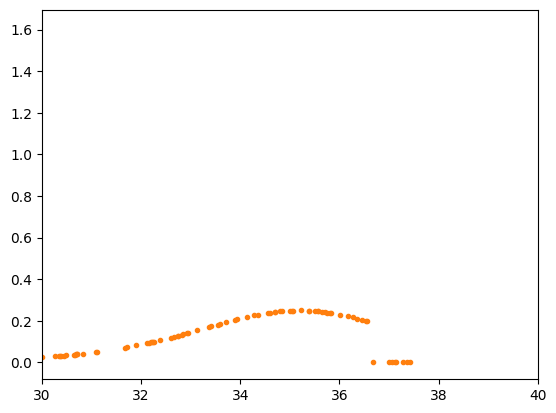

In [128]:
plt.plot(tx_boundary[:,1:],y_boundary,'.')
# plt.plot( tx_init[:,1:],u_init,'.')
plt.plot( tx_init[:,1:],phi_function(tx_init),'.')
plt.xlim([30,40])
inputs = [tx_eqn, tx_init, tx_boundary, tx_boundary, tx_boundary]
outputs = [phi_function(tx_eqn), y_eqn, y_init, y_boundary]


In [129]:
# print(phi_function(tx_eqn)[0:11])
# print(phi_function(tx_eqn[9:10,:]))
sol, denom, numer = phi_function(tx_init, returnStuff=True)
for ind,f in enumerate(tx_init): 
    sol, denom, numer = phi_function(tx_init[ind:ind+1,:], returnStuff=True)
    if tf.math.is_nan(sol) == True:
        print(denom)
        print('numer', numer)
        print('values',tx_init[ind:ind+1,:])
        
# [[inf]]
# numer [[inf]]
# values tf.Tensor([[ 0.       37.840843]], shape=(1, 2), dtype=float32)
# [[inf]]
# numer [[inf]]


tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
numer tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
values tf.Tensor([[ 0.       40.625458]], shape=(1, 2), dtype=float32)
tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
numer tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
values tf.Tensor([[ 0.       40.643745]], shape=(1, 2), dtype=float32)
tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
numer tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
values tf.Tensor([[ 0.       39.983334]], shape=(1, 2), dtype=float32)
tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
numer tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
values tf.Tensor([[ 0.       46.339443]], shape=(1, 2), dtype=float32)
tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
numer tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
values tf.Tensor([[ 0.       43.682247]], shape=(1, 2), dtype=float32)
tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
numer tf.Tensor([[inf]], shape=(1, 1), dtype=float32)
values tf.Tensor([[ 0.       48.1

In [130]:
val =  tf.constant([[ 0.   ,    37.840843]], shape=(1, 2), dtype=tf.float32)
print(phi_function(val))

tf.Tensor([[nan]], shape=(1, 1), dtype=float32)


nan

In [75]:
backbone = create_dense_model([32, 64, 64, 64, 32], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
pinn = KdVPinn(backbone, k=6.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [76]:
history = pinn.fit_custom(inputs, outputs, epochs = 5000, print_every = 500)

Epoch 0, Loss Residual: 0.0465, Loss Initial: 0.5365, Loss Boundary: 0.6111, MAE: 0.5322
Epoch 500, Loss Residual: 0.0002, Loss Initial: 0.0481, Loss Boundary: 0.0005, MAE: 0.1216
Epoch 1000, Loss Residual: 0.0000, Loss Initial: 0.0136, Loss Boundary: 0.0000, MAE: 0.1140
Epoch 1500, Loss Residual: 0.0000, Loss Initial: 0.0096, Loss Boundary: 0.0000, MAE: 0.1146
Epoch 2000, Loss Residual: 0.0000, Loss Initial: 0.0064, Loss Boundary: 0.0000, MAE: 0.1162
Epoch 2500, Loss Residual: 0.0000, Loss Initial: 0.0021, Loss Boundary: 0.0000, MAE: 0.1166
Epoch 3000, Loss Residual: 0.0000, Loss Initial: 0.0002, Loss Boundary: 0.0000, MAE: 0.1137
Epoch 3500, Loss Residual: 0.0000, Loss Initial: 0.0001, Loss Boundary: 0.0000, MAE: 0.1112
Epoch 4000, Loss Residual: 0.0000, Loss Initial: 0.0001, Loss Boundary: 0.0000, MAE: 0.1100
Epoch 4500, Loss Residual: 0.0000, Loss Initial: 0.0002, Loss Boundary: 0.0000, MAE: 0.1118


In [9]:
history = pinn.fit(inputs, outputs, epochs= 20000, batch_size=tx_samples.shape[0], verbose=0)
# history = pinn.fit_custom(inputs, outputs, epochs=20000, print_every = 1000)

In [26]:
pinn.get_metrics_result()


{'loss_total': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'loss_residual': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'loss_initial': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'loss_boundary': <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=nan>}

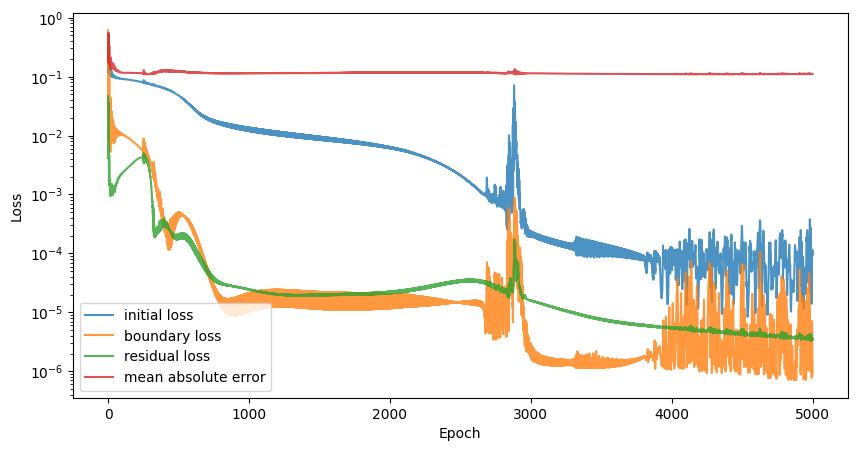

In [77]:
plot_training_loss(history, y_scale='log')

1/1 [==============================] - 0s 35ms/step


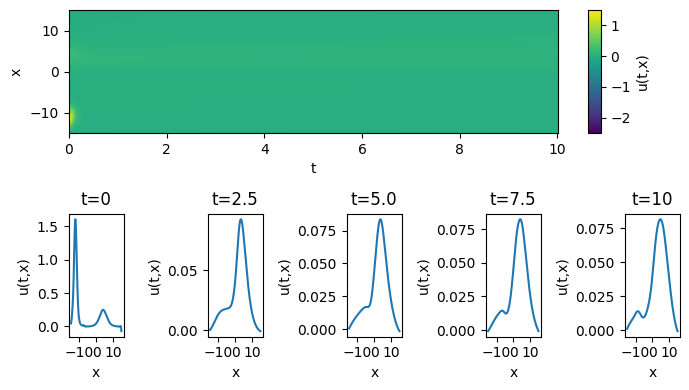

In [78]:
plot_KdV_model(pinn.backbone, x_start,length, time, -2.5, 1.5, save_path = None, show=True) 

In [137]:



backbone2 = create_dense_model([64, 64], activation='tanh', initializer='glorot_normal', \
n_inputs=2, n_outputs=1)
layer1 = pinn.backbone.get_layer(index=1) 
layer_new = backbone2.get_layer(index=1) 
layer2 = pinn.backbone.get_layer(index=2) 
layer_new2 = backbone2.get_layer(index=2) 
tx_weights1 = layer1.get_weights()[0] # first axis used for t and x, e.g. [:1,:]
biases = layer1.get_weights()[1]
tx_weights2 = layer2.get_weights()[0] 
biases2 = layer2.get_weights()[1]
layer_new.set_weights([tx_weights1, biases])
layer_new2.set_weights([tx_weights2, biases2])
# penal = 1-0.25*ii
pinn2 = KdVPinn(backbone2, k=6.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.82)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn2.compile(optimizer=optimizer)
history2 = pinn2.fit_custom(inputs, outputs, epochs=10000, print_every= 1000) # input and output was changed according to two-soliton



Epoch 0, Loss Residual: 0.0579, Loss Initial: nan, Loss Boundary: 0.3862, MAE: nan
Epoch 1000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 2000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 3000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 4000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 5000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 6000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 7000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 8000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan
Epoch 9000, Loss Residual: nan, Loss Initial: nan, Loss Boundary: nan, MAE: nan


In [84]:
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)
    # t_, x_ = tf.meshgrid(t_flat, x_flat)
    # tx = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
    # solution = phi_function_PBC(tx,num_test_samples ,num_test_samples)
    # solution = tf.reshape(solution, x_.shape)
    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))
        print(int(t_cs/dt+1))
        # plt.plot(x_flat, solution[:,int(t_cs/dt)], label = 'exact')
        plt.plot(x_flat, phi_function(tx), '.',label = 'exact at time {}'.format(t_cs))
        plt.legend()
        plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
    return

(1000, 2)
1/1 [==============================] - 0s 178ms/step
500


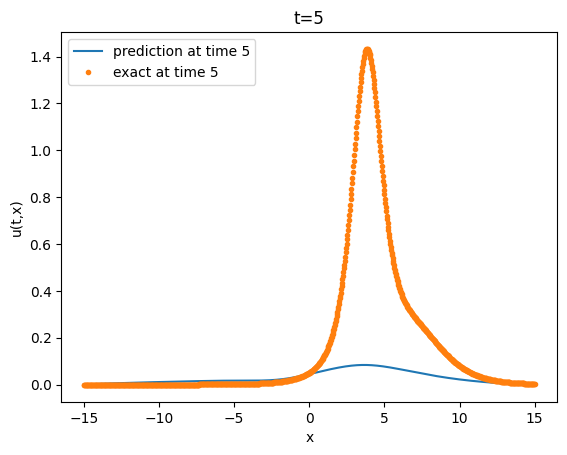

In [86]:
plot_snapshots([5])